In [71]:
%matplotlib inline
import pandas as pd
import re
import seaborn as sns
import csv
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import pickle
import multiprocessing as mp
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

from scipy import stats


In [99]:
df = pickle.load( open( "movies_df.pickle", "rb" ) )
no_titles = df.drop(columns=['movie_title', 'audience scores', 'rating'])
no_titles

pickle.dump(no_titles, open('all_features.pickle', 'wb'))

no_nans = no_titles.loc[no_titles['metascores'] != 0.0]
no_nans = no_nans.drop(columns=['rating_G', 'rating_PG', 'rating_M/PG', 'rating_PG-13', 'rating_R', 'runtime_minutes'])
no_nans

pickle.dump(no_nans, open('no_nan.pickle', 'wb'))

In [3]:
X = no_nans.drop(columns=['domestic_total_gross'])
y = no_nans['domestic_total_gross']

In [4]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [6]:
std = StandardScaler()
std.fit(X_train.values)

X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

(array([137., 113.,  90.,  56.,  55.,  33.,  30.,  23.,  18.,  10.]),
 array([-1.22077612, -0.81193776, -0.4030994 ,  0.00573896,  0.41457732,
         0.82341568,  1.23225404,  1.6410924 ,  2.04993076,  2.45876912,
         2.86760748]),
 <a list of 10 Patch objects>)

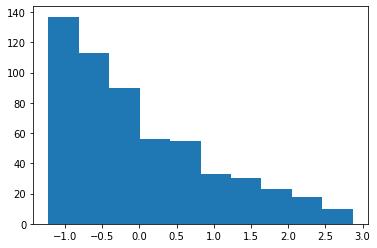

In [39]:
plt.hist(X_tr[:, -2])

In [59]:
lasso_model = Lasso(alpha = 100)
lasso_model.fit(X_tr, y_train)

Lasso(alpha=100)

In [60]:
list(zip(X_train.columns, lasso_model.coef_))

[('budget', 44174908.64425828),
 ('metascores', 2794069.634233055),
 ('audience_scores', 2033876.3153219856),
 ('critic_count', 1653277.7811983903),
 ('num_audience_ratings', 17054452.731435444)]

In [61]:
selected_columns = ['budget', 'metascores', 'audience_scores', 'critic_count', 'num_audience_ratings']

In [62]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

In [63]:
alphalist = 10**(np.linspace(-2, 2, 200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i, curr_alpha in enumerate(alphalist):
    steps = [('standardize', StandardScaler()),
            ('lasso', Lasso(alpha = curr_alpha))]
    
    pipe = Pipeline(steps)
    pipe.fit(X_train.loc[:, selected_columns].values, y_train)
    
    val_set_pred = pipe.predict(X_val.loc[:, selected_columns].values)
    err_vec_val[i] = mae(y_val, val_set_pred)

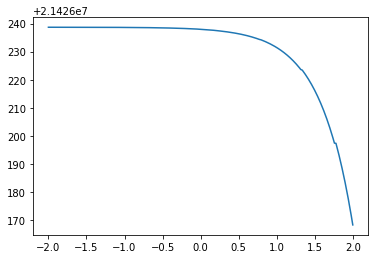

In [64]:
plt.plot(np.log10(alphalist), err_vec_val)

In [65]:
np.min(err_vec_val)

21426168.39211748

In [66]:
alphalist[np.argmin(err_vec_val)]

100.0

In [67]:
lasso_model = Lasso(alpha = 100)
lasso_model.fit(X_train, y_train)

Lasso(alpha=100)

In [68]:
list(zip(selected_columns, lasso_model.coef_))

[('budget', 1.2589451666663452),
 ('metascores', 177261.54177021846),
 ('audience_scores', 687369.4130861197),
 ('critic_count', 116540.49410894883),
 ('num_audience_ratings', 34247.32700714968)]

In [70]:
np.random.seed(6)

X_train_collinear = X_train.loc[:, selected_columns]

X_train_collinear.corr()

,budget,metascores,audience_scores,critic_count,num_audience_ratings
budget,1.000000,-0.045856,0.137412,0.414178,0.481028
metascores,-0.045856,1.000000,0.123568,0.068332,0.020438
audience_scores,0.137412,0.123568,1.000000,0.474878,0.199902
critic_count,0.414178,0.068332,0.474878,1.000000,0.441671
num_audience_ratings,0.481028,0.020438,0.199902,0.441671,1.000000


In [72]:
model = sm.OLS(y_train, sm.add_constant(X_train_collinear))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     domestic_total_gross   R-squared:                       0.666
Model:                              OLS   Adj. R-squared:                  0.663
Method:                   Least Squares   F-statistic:                     222.9
Date:                  Thu, 16 Jul 2020   Prob (F-statistic):          1.56e-130
Time:                          01:38:04   Log-Likelihood:                -10684.
No. Observations:                   565   AIC:                         2.138e+04
Df Residuals:                       559   BIC:                         2.141e+04
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.365e+07   7.47e+06     -1.827      0.068   -2.83e+07    1.03e+06
budget                   1.2589      0.056     22.310      0.000       1.148       1.370
metascores            1.773e+05   1.07e+05      1.657      0.098   -3.29e+04    3.87e+05
audience_scores       6.874e+05   6.46e+05      1.065      0.287   -5.81e+05    1.96e+06
critic_count          1.165e+05   1.51e+05      0.770      0.442   -1.81e+05    4.14e+05
num_audience_ratings  3.425e+04   4012.090      8.536      0.000    2.64e+04    4.21e+04
==============================================================================
Omnibus:                      413.308   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12082.469
Skew:                           2.837   Prob(JB):                         0.00
Kurtosis:                      24.933   Cond. No.                     1.67e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.67e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [73]:
lr_model_ridge = Ridge(alpha = 10000000000)
lr_model_ridge.fit(X_train_collinear, y_train)

list(zip(X_train_collinear.columns, lr_model_ridge.coef_))

[('budget', 1.5139290442648894),
 ('metascores', 3.4852148457592667),
 ('audience_scores', 0.8869836294531083),
 ('critic_count', 5.251443401727206),
 ('num_audience_ratings', 386.9218607462623)]

In [74]:
lr_model_lasso = Lasso(alpha = 100000)
lr_model_lasso.fit(X_train_collinear, y_train)

list(zip(X_train_collinear.columns, lr_model_lasso.coef_))

[('budget', 1.2589254999249824),
 ('metascores', 177113.65316497124),
 ('audience_scores', 674185.506316457),
 ('critic_count', 117276.5527731043),
 ('num_audience_ratings', 34254.08483741959)]

In [91]:
test_set_pred = lasso_model.predict(X_test.loc[:, selected_columns])

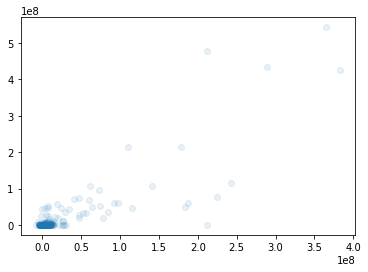

In [92]:
plt.scatter(test_set_pred, y_test, alpha=.1)
plt.plot(np.linspace(0, 600000, 1000), np.linspace(0, 600000, 1000))

In [93]:
r2_score(y_test, test_set_pred)

0.7046528293461451

In [80]:
test_set_pred = lr_model_ridge.predict(X_test.loc[:, selected_columns])

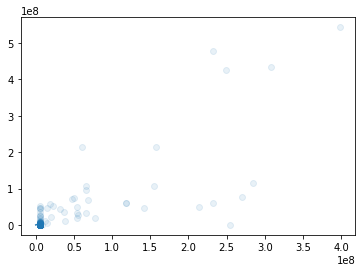

In [88]:
plt.scatter(test_set_pred, y_test, alpha=.1)
plt.plot(np.linspace(0, 600000, 1000), np.linspace(0, 600000, 1000))

In [89]:
r2_score(y_test, test_set_pred)

0.6110537041234264

In [95]:
from sklearn.linear_model import lars_path
## Scale the variables
std = StandardScaler()
std.fit(X_train.values)

X_tr = std.transform(X_train.values)

## Note: lars_path takes numpy matrices, not pandas dataframes

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso')

Computing regularization path using the LARS ...


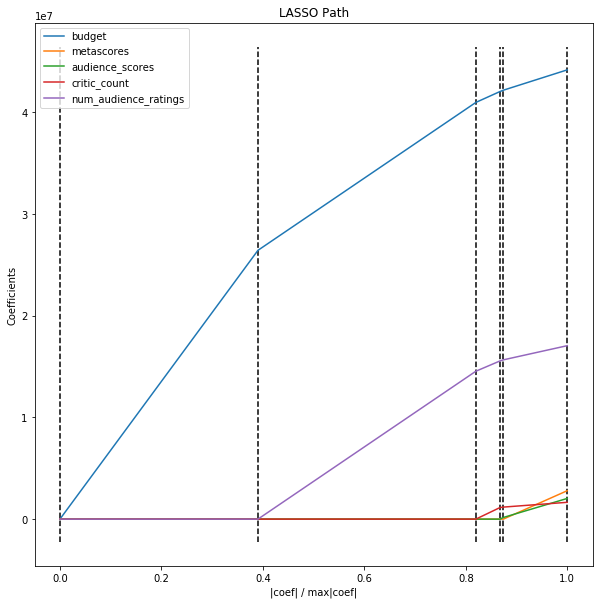

In [96]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()